# Prediction Task:
## _Predict bike rental demand as a function of suitable features available in or derived from the data sets_

## Libraries and styles

In [1]:
# importing all relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime, timedelta
from haversine import haversine, Unit
from matplotlib.dates import date2num

In [2]:
# set seaborn styles
sns.set()
sns.set_style("whitegrid")
sns.set_palette("rocket")

# set pandas display styles
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 2000)
pd.set_option('display.max_rows', 500)
%config IPCompleter.greedy=True

## Reading Function

In [3]:
def read_data(city_name):
    trip_data = pd.read_csv("Project_Data/Combined_Data/"+city_name+".csv", encoding = "ISO-8859-1")
    trip_data["trip_duration"] = pd.to_timedelta(trip_data["trip_duration"])
    trip_data["datetime_start"] = pd.to_datetime(trip_data["datetime_start"])
    trip_data["datetime_end"] = pd.to_datetime(trip_data["datetime_end"])
    trip_data["time"] = pd.to_datetime(trip_data["time"])
    trip_data["day"] = pd.to_datetime(trip_data["day"])
    return trip_data

In [4]:
dataBr = read_data("Bremen")
dataDu = read_data("Duesseldorf")

In [5]:
city1 = "Bremen"
city2 = "Duesseldorf"
start_date = "2019-02-01 00:00:00"
end_date = "2019-06-30 23:59:00"
startDate = datetime.fromisoformat(start_date)
endDate = datetime.fromisoformat(end_date)

In [6]:
# coordinates of city center as [lat, lng]
br_center = [53.078893247451994, 8.8027747491885]
du_center = [51.226815497281706, 6.773786392066722]

In [7]:
dataBr["distance_from_center_start"] = dataBr.apply(lambda row: haversine((row["orig_lat"], row["orig_lng"]),(br_center[0], br_center[1]),Unit.KILOMETERS), axis=1) 
dataBr["distance_from_center_end"] = dataBr.apply(lambda row: haversine((row["dest_lat"], row["dest_lng"]),(br_center[0], br_center[1]),Unit.KILOMETERS), axis=1) 
dataDu["distance_from_center_start"] = dataDu.apply(lambda row: haversine((row["orig_lat"], row["orig_lng"]),(du_center[0], du_center[1]),Unit.KILOMETERS), axis=1) 
dataDu["distance_from_center_end"] = dataDu.apply(lambda row: haversine((row["dest_lat"], row["dest_lng"]),(du_center[0], du_center[1]),Unit.KILOMETERS), axis=1) 

## Data for Prediction Task

### Prepare data
Since we have data sets with single entries (trips) at one specific point of time, it does not make sense to take a value from the single entries as a target (since there is no "rental demand" associated with a single trip). Rather, we have to group the trips by a time unit, e.g. hour or day, and aggregate the number of trips per time unit, so there is a target associated with our data that can be predicted.

In [8]:
dataBr.head()

,Unnamed: 0,day,time,b_number,city,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,...,fleetsize_monthly,distance,trip_duration_hours,avg_speed,rounded_time_hourly,temp,wind,rain,distance_from_center_start,distance_from_center_end
0,0,2019-04-21,2021-01-28 17:34:00,20507,bremen,00:13:00,53.078923,8.884911,53.078711,8.899906,...,395,1.001900,0.216667,4.624155,2019-04-21 18:00:00,20.4,2.0,0.0,5.486415,6.488083
1,1,2019-05-23,2021-01-28 15:33:00,20507,bremen,00:07:00,53.078923,8.884911,53.078004,8.876828,...,373,0.549476,0.116667,4.709793,2019-05-23 16:00:00,20.7,2.4,0.0,5.486415,4.947560
2,2,2019-06-14,2021-01-28 22:30:00,20507,bremen,00:08:00,53.078923,8.884911,53.074731,8.876003,...,342,0.755886,0.133333,5.669146,2019-06-14 22:00:00,19.6,4.4,0.0,5.486415,4.913475
3,3,2019-06-16,2021-01-28 10:00:00,20507,bremen,02:02:00,53.074731,8.876003,53.078923,8.884911,...,342,0.755886,2.033333,0.371747,2019-06-16 10:00:00,21.6,3.0,0.0,4.913475,5.486415
4,4,2019-06-16,2021-01-28 12:55:00,20507,bremen,02:23:00,53.078923,8.884911,53.076236,8.891322,...,342,0.522213,2.383333,0.219110,2019-06-16 13:00:00,21.8,4.4,0.0,5.486415,5.922224


#### Drop columns that are obviously neither relevant nor useful

In [9]:
dBr = dataBr.drop(["Unnamed: 0","b_number","day","time","city","fleetsize_weekly","fleetsize_dayly","fleetsize_monthly"], axis=1)
dDu = dataDu.drop(["Unnamed: 0","b_number","day","time","city","fleetsize_weekly","fleetsize_dayly","fleetsize_monthly"], axis=1)

In [10]:
# group the trips by either hour or day
def process_data_for_city(data, city, start_date, end_date, group):
    '''
    Processes given data and calculates the revenue per hour for a given city in a given time window. Also groups by 
    a given param (hour or day)

    :param data: the dataFrame of a given city
    :param city: a city in string format, e.g. "Bremen" or "Duesseldorf"
    :param start_date: an iso format time string, e.g. "2019-03-28 12:00:00"
    :param end_date: an iso format time string, e.g. "2019-03-31 12:00:00"
    :param group: a string, either "hour" or "day"
    '''

    # sorting of data
    dat = data.sort_values(by=['datetime_start'], axis=0)
 
    def calc_revenue(x):
        '''
        Counts trip duration intervals for each trip, i.e. how much revenue each trip generated,
        by setting the revenue to the number of 30-minute durations fitting into the trip duration,
        and add 1 to the revenue if division of trip duration by 30-minute interval has a remainder
        
        Examples: 
        If a trip was 30 mins long: trip duration / 30 mins --> revenue = 1 
        If a trip was 1 hour 12 mins long: trip duration / 30 mins = 2, remainder = 12 --> revenue = 2+1 = 3
        
        :param x: a trip/row
        '''
        if (x % pd.Timedelta(minutes=30)) > pd.Timedelta(minutes=0):
            return float(math.floor(x / pd.Timedelta(minutes=30) + 1))
        else:
            return float(math.floor(x / pd.Timedelta(minutes=30)))
                              
    # apply calculation to each row
    dat["revenue_per_trip"] = dat["trip_duration"].apply(lambda x: calc_revenue(x))

    # select rows in the given time window
    dat_time_framed = dat.loc[(dat["datetime_start"] > startDate) & (dat["datetime_start"] <= endDate)]
    
    
    # Group data in the given time window by month, day and hours to get to specific hourly level
    # and aggregate on several columns
    times = pd.DatetimeIndex(dat_time_framed.datetime_start)
    grouping = [times.month, times.day, times.hour] if group == "hour" else  [times.month, times.day]
    groupedBy = dat_time_framed.groupby(grouping).agg(trips_per_time=("datetime_start","count"), revenue_per_time=("revenue_per_trip","sum"), avg_temp=("temp","mean"), avg_wind=("wind","mean"), avg_rain=("rain","mean"), avg_distance=("distance","mean"), avg_dist_from_center_start=("distance_from_center_start","mean"), avg_dist_from_center_end=("distance_from_center_end","mean"))
   
    # reset index to get the groupedBy values back as columns
    groupedBy.index.rename(["month", "day", "hour"] if group == "hour" else ["month","day"], inplace=True)
    groupedBy.reset_index(inplace=True)
    
    # generate string date column
    groupedBy["date"] = "2019-" + groupedBy["month"].astype(str) + "-" +  groupedBy["day"].astype(str) + " 00:00:00"

    # generate datetime column for checking of weekdays and remove string date column
    groupedBy["datetime"] = [pd.to_datetime(d) for d in groupedBy.date]
    groupedBy.drop(["date"], axis=1, inplace=True)

    # generate weekday column for later use
    groupedBy["weekday"] = [dt.weekday() for dt in groupedBy.datetime]
    groupedBy.drop(["datetime"], axis=1, inplace=True)


    # check, if date is weekday (.weekday() returns 0 for a monday, and 6 for a sunday)
    groupedBy["is_weekday"] = groupedBy["weekday"] <=4
    groupedBy.drop(["weekday"], axis=1, inplace=True)

    
    return groupedBy

In [11]:
TIME_FRAME="day"

In [12]:
br = process_data_for_city(dBr, city1, startDate, endDate, TIME_FRAME)
du = process_data_for_city(dDu, city2, startDate, endDate, TIME_FRAME) 

In [13]:
br.head(15)

,month,day,trips_per_time,revenue_per_time,avg_temp,avg_wind,avg_rain,avg_distance,avg_dist_from_center_start,avg_dist_from_center_end,is_weekday
0,2,1,197,226.0,0.060914,4.290863,0.000000,1.524199,1.875367,1.968714,True
1,2,2,118,152.0,0.450847,3.150000,0.000000,1.489424,1.774694,1.954111,False
2,2,3,139,169.0,1.653957,3.487050,0.000000,1.590335,1.724617,1.780380,False
3,2,4,162,182.0,2.485802,5.846296,0.000000,1.742222,2.154845,2.272686,True
4,2,5,227,272.0,3.875330,4.803965,0.000000,1.587274,1.899668,1.835590,True
5,2,6,189,226.0,4.842328,4.136508,0.176190,1.633971,1.906559,1.925526,True
6,2,7,246,281.0,7.625610,7.655285,0.031301,1.468920,1.975020,2.027243,True
7,2,8,287,361.0,7.823345,7.123345,0.004181,1.467289,1.940635,2.033037,True
8,2,9,174,204.0,8.030460,9.227011,0.050575,1.391234,2.299408,2.291393,False
9,2,10,100,108.0,7.146000,7.265000,0.297000,1.675600,1.872859,2.052113,False


### Correlation Analysis

The goal is to select those features (from the set of all features) that are optimally least correlated with each other and highly correlated with the target. As a guideline we could take a boundary correlation value of 0.3 or -0.3 to detect very low correlation and take at least low to medium correlation into consideration. However, some features with low correlation values still might be valuable for the prediction task, and a low correlation value might not filter those out (e.g. wind strength obviously has an impact on driven distance). As a result, all features with correlation below between 0.05 and -0.05 are considered not correlated with each other and are assumed to be able to be independently used in a feature set. The same values apply to selecting those features correlated with the target. However, correlation with the target should be maximized.

https://journals.sagepub.com/doi/pdf/10.1177/875647939000600106
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3576830/

#### on unprepared data

In [14]:
# showing the highest correlation values for a given data set with a given correlation metric
# disregards values equal to 1 at the diagonal
def show_high_corr(data, posMin, negMin, corr_method):
    corr = data.corr(method=corr_method)
    corr_val = np.array(corr)
    rows, cols = corr.shape
    flds = list(corr.columns)
    high_corr = []
    
    for i in range(cols):
        for j in range(i, cols):
            if corr_val[i,j] > posMin or corr_val[i,j] < negMin:
                if(i!=j):
                    high_corr.append([flds[i], flds[j], corr_val[i,j]])
    df = pd.DataFrame(high_corr, columns = ['col1', 'col2', 'correlation'])
    return df

In [15]:
# BREMEN, PEARSON CORRELATION
all_br_pe = show_high_corr(dBr, 0.05, -0.05, "pearson")
all_br_pe

,col1,col2,correlation
0,orig_lat,orig_lng,-0.070743
1,orig_lat,dest_lat,0.666620
2,orig_lat,dest_lng,-0.069857
3,orig_lat,distance,0.098017
4,orig_lat,trip_duration_hours,0.056897
5,orig_lat,distance_from_center_end,-0.064568
6,orig_lng,dest_lat,-0.066708
7,orig_lng,dest_lng,0.642663
8,orig_lng,distance,0.050057
9,orig_lng,distance_from_center_start,0.519234


In [16]:
# BREMEN, SPEARMAN CORRELATION
all_br_sp = show_high_corr(dBr, 0.05, -0.05, "spearman")
all_br_sp

,col1,col2,correlation
0,orig_lat,dest_lat,0.455863
1,orig_lat,distance,0.060518
2,orig_lat,trip_duration_hours,0.050182
3,orig_lng,dest_lng,0.516679
4,orig_lng,distance_from_center_start,0.557024
5,orig_lng,distance_from_center_end,0.316041
6,dest_lat,hour,-0.065336
7,dest_lat,distance,0.056946
8,dest_lng,hour,0.088366
9,dest_lng,distance_from_center_start,0.317261


##### Bremen
- geo coordinates have a strong positive correlation with each other
- geo coordinates have a strong positive correlation with distance from city center

**-->** remove geo coordinates or take only one out of those features with geo coordinates / distance from center

- month, hour and week are highly positively correlated with temp

**-->** try maybe with one out of [month,day,hour] plus temperature (e.g. since both hour and temp could be a valuable feature), or only temperature, or only time values

- distance is highly correlated with trip duration in hours, average speed

**-->** here, take only one feature, since they all rely on each other


**lower correlation values that still might be relevant**
- distance is negatively correlated with wind
- trip duration is positively correlated with wind
- avg speed is negatively correlated with temperature
- temperature is negatively correlated with rain
- weekday is positively correlated with trip duration and negatively correlated with average speed

In [21]:
# DÜSSELDORF, PEARSON CORRELATION
all_du_pe = show_high_corr(dDu, 0.05, -0.05, "pearson")
all_du_pe

,col1,col2,correlation
0,orig_lat,orig_lng,-0.111232
1,orig_lat,dest_lat,0.720237
2,orig_lat,dest_lng,-0.098727
3,orig_lat,month,-0.115170
4,orig_lat,week,-0.127535
5,orig_lat,distance,0.218181
6,orig_lat,trip_duration_hours,0.064961
7,orig_lat,avg_speed,0.072530
8,orig_lat,temp,-0.107898
9,orig_lat,distance_from_center_start,0.114302


In [22]:
# DÜSSELDORF, SPEARMAN CORRELATION
results_du_sp = show_high_corr(dDu, 0.299, -0.299, "spearman")
results_du_sp

,col1,col2,correlation
0,orig_lat,dest_lat,0.625418
1,orig_lng,dest_lng,0.462044
2,orig_lng,distance_from_center_start,0.377244
3,dest_lng,distance_from_center_end,0.366026
4,month,week,0.901037
5,month,temp,0.660971
6,week,temp,0.710122
7,distance,trip_duration_hours,0.466940
8,distance,avg_speed,0.541234
9,trip_duration_hours,avg_speed,-0.351040


##### Düsseldorf
- similar to Bremen


#### on prepared data

In [23]:
# BREMEN, PEARSON CORRELATION
prep_br_pe = show_high_corr(br, 0.05, -0.05, "pearson")
prep_br_pe

,col1,col2,correlation
0,month,trips_per_time,0.786801
1,month,revenue_per_time,0.776149
2,month,avg_temp,0.779400
3,month,avg_wind,-0.104318
4,month,avg_distance,0.444272
5,month,avg_dist_from_center_start,0.271653
6,month,avg_dist_from_center_end,0.286518
7,day,trips_per_time,0.260044
8,day,revenue_per_time,0.283895
9,day,avg_temp,0.292021


In [24]:
# BREMEN, SPEARMAN CORRELATION
prep_br_sp = show_high_corr(br, 0.05, -0.05, "spearman")
prep_br_sp

,col1,col2,correlation
0,month,trips_per_time,0.809593
1,month,revenue_per_time,0.809974
2,month,avg_temp,0.777366
3,month,avg_rain,0.054557
4,month,avg_distance,0.440068
5,month,avg_dist_from_center_start,0.324406
6,month,avg_dist_from_center_end,0.335327
7,day,trips_per_time,0.240675
8,day,revenue_per_time,0.275521
9,day,avg_temp,0.293767


In [25]:
# DÜSSELDORF, PEARSON CORRELATION
prep_du_pe = show_high_corr(du, 0.05, -0.05, "pearson")
prep_du_pe

,col1,col2,correlation
0,month,trips_per_time,0.796455
1,month,revenue_per_time,0.789888
2,month,avg_temp,0.710187
3,month,avg_wind,-0.209496
4,month,avg_distance,-0.270968
5,month,avg_dist_from_center_start,-0.229479
6,month,avg_dist_from_center_end,-0.255924
7,day,trips_per_time,0.267361
8,day,revenue_per_time,0.280449
9,day,avg_temp,0.352352


In [26]:
# DÜSSELDORF, SPEARMAN CORRELATION
prep_du_sp = show_high_corr(du, 0.05, -0.05, "spearman")
prep_du_sp

,col1,col2,correlation
0,month,trips_per_time,0.871109
1,month,revenue_per_time,0.850030
2,month,avg_temp,0.701832
3,month,avg_wind,-0.152542
4,month,avg_rain,0.083930
5,month,avg_distance,-0.288226
6,month,avg_dist_from_center_start,0.050654
7,day,trips_per_time,0.284114
8,day,revenue_per_time,0.284344
9,day,avg_temp,0.375459


similar to above, but:
- month is highly correlated with num of trips (**target**), revenue and avg temp
- hour is highly correlated with num of trips (**target**)
- day is slightly correlated with num of trips (**target**), revenue and avg temp
- num of trips (**target**) is highly correlated with revenue and temp

**condensed for target variable: correlation of features with target variable on prepared data set**

In [27]:
target_corr_br = pd.DataFrame(data=pd.DataFrame(data=br.corr(method="pearson"))["trips_per_time"]).rename(columns={"trips_per_time": "pearson"})
target_corr_br["spearman"] = pd.DataFrame(data=br.corr(method="spearman"))["trips_per_time"]
target_corr_br

,pearson,spearman
month,0.786801,0.809593
day,0.260044,0.240675
trips_per_time,1.000000,1.000000
revenue_per_time,0.968975,0.974578
avg_temp,0.773797,0.798939
avg_wind,-0.261141,-0.200908
avg_rain,-0.230241,-0.164318
avg_distance,0.477721,0.479616
avg_dist_from_center_start,0.201756,0.252130
avg_dist_from_center_end,0.182967,0.239908


In [28]:
target_corr_du = pd.DataFrame(data=pd.DataFrame(data=du.corr(method="pearson"))["trips_per_time"]).rename(columns={"trips_per_time": "pearson"})
target_corr_du["spearman"] = pd.DataFrame(data=du.corr(method="spearman"))["trips_per_time"]
target_corr_du

,pearson,spearman
month,0.796455,0.871109
day,0.267361,0.284114
trips_per_time,1.000000,1.000000
revenue_per_time,0.988414,0.992051
avg_temp,0.829426,0.839187
avg_wind,-0.229494,-0.278209
avg_rain,-0.116022,-0.161168
avg_distance,-0.213642,-0.165879
avg_dist_from_center_start,-0.118306,0.044670
avg_dist_from_center_end,-0.135398,-0.045207


### Suitable features
#### those features from pepared data set with corr > 0.05 or < -0.05 and which are assumed to have impact on rental, sorted by assumed impact on rental demand
- temp
- month
- day
- wind
- rain
- avg distance
- distance from city center
- weekday

## Select features

In [29]:
# all possible pre-selected features
# ["month", "day", "avg_temp", "avg_wind", "avg_rain", "avg_distance", "avg_dist_from_center_end", "is_weekday"]

##### split into weekday, weekend and combined

In [30]:
x_br_weekday = br[br["is_weekday"]==True][["month", "day", "avg_temp", "avg_wind", "avg_rain", "avg_distance", "avg_dist_from_center_end"]]
x_br_weekend = br[br["is_weekday"]==False][["month", "day", "avg_temp", "avg_wind", "avg_rain","avg_distance", "avg_dist_from_center_end"]]
x_br_full    = br[["month", "day", "avg_temp", "avg_wind", "avg_rain", "avg_distance", "avg_dist_from_center_end", "is_weekday"]]
y_br_weekday = br[br["is_weekday"]==True]["trips_per_time"]
y_br_weekend = br[br["is_weekday"]==False]["trips_per_time"]
y_br_full = br["trips_per_time"]

##### automatically select k best features (features n=8)

In [31]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler

In [32]:
br_new_wd = SelectKBest(f_regression, k=7).fit_transform(x_br_full,y_br_full)
pd.DataFrame(br_new_wd)

,0,1,2,3,4,5,6
0,2,1,0.0609137,4.29086,0,1.5242,True
1,2,2,0.450847,3.15,0,1.48942,False
2,2,3,1.65396,3.48705,0,1.59033,False
3,2,4,2.4858,5.8463,0,1.74222,True
4,2,5,3.87533,4.80396,0,1.58727,True
5,2,6,4.84233,4.13651,0.17619,1.63397,True
6,2,7,7.62561,7.65528,0.0313008,1.46892,True
7,2,8,7.82334,7.12334,0.00418118,1.46729,True
8,2,9,8.03046,9.22701,0.0505747,1.39123,False
9,2,10,7.146,7.265,0.297,1.6756,False


#### results from playing around with x_br_weekday, x_br_weekend, x_br_full with k = 1,...,7
##### best k features from k=1 to k=7 on weekdays
- month
- month, temp
- month, temp, avg_distance
- month, temp, avg_distance, avg_dist_from_center_end
- month, temp, avg_wind, avg_distance, avg_dist_from_center_end
- month, day, temp, avg_wind, avg_distance, avg_dist_from_center_end
- month, day, temp, avg_wind, rain, avg_distance, avg_dist_from_center_end

##### best k features from k=1 to k=7 on weekends
- month
- month, temp
- month, temp, avg_distance
- month, temp, rain, avg_distance
- month, day, temp, rain, avg_distance
- month, day, temp, wind, rain, avg_distance
- month, day, temp, wind, rain, avg_distance, avg_dist_from_center_end 

##### best k features from k=1 to k=7 on all days
- month
- month, temp
- month, temp, avg_distance
- month, temp, wind, avg_distance
- month, day, temp, wind, avg_distance
- month, day, temp, wind, rain, avg_distance
- month, day, temp, wind, rain, avg_distance, is_weekday

##### for both weekday and weekend  temperature the 3 most important features seem to be month, temp and avg_distance

##### selected features for prediction

In [33]:
x_br_weekday = br[br["is_weekday"]==True][["month", "day", "avg_temp", "avg_wind", "avg_rain", "avg_distance", "avg_dist_from_center_end"]]
x_br_weekend = br[br["is_weekday"]==False][["month", "day", "avg_temp", "avg_wind", "avg_rain", "avg_distance", "avg_dist_from_center_end"]]
y_br_weekday = br[br["is_weekday"]==True]["trips_per_time"]
y_br_weekend = br[br["is_weekday"]==False]["trips_per_time"]

# SELECT FEATURES HERE
features = ["month", "day", "avg_temp", "avg_wind", "avg_rain", "avg_dist_from_center_end", "is_weekday"]
LABEL_FOR_GRAPHS="avg_temp"

# X_weekday = x_br_weekday[features]
# X_weekend = x_br_weekend[features]
X_full    = br[features]

y_weekday = y_br_weekday
y_weekend = y_br_weekend
y_full = br["trips_per_time"]

# Regression

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

In [35]:
# split the data with 50% in each set
SPLIT_TRAIN = 0.5
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, random_state=0, train_size=SPLIT_TRAIN)

## target values, train and test

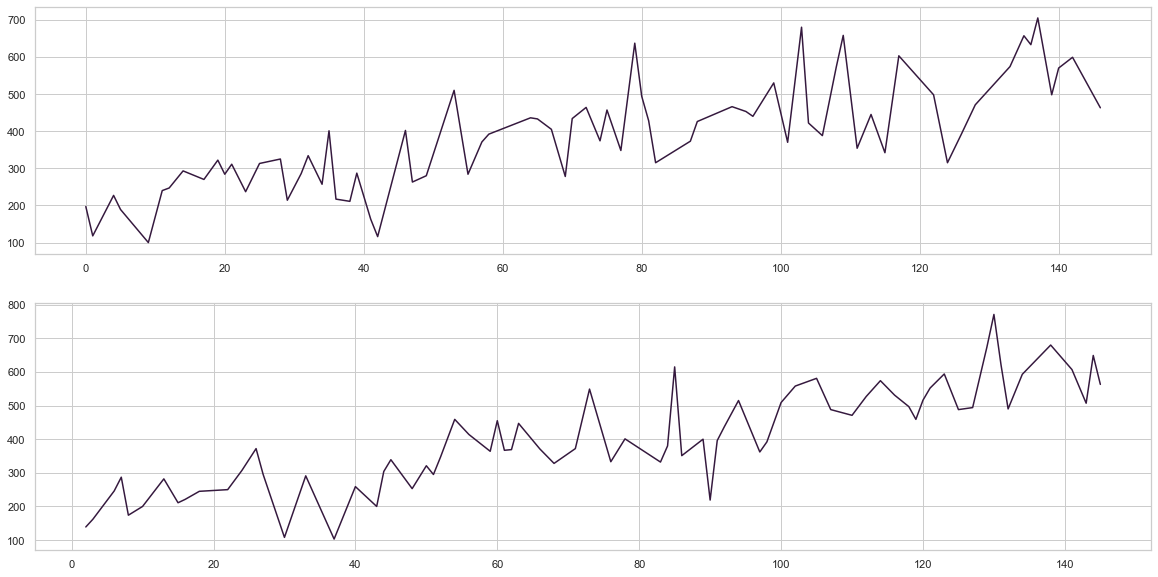

In [36]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
sns.lineplot(data=y_train, ax=ax1)
sns.lineplot(data=y_test, ax=ax2)

## Model: Linear regression, for comparison

Linear Regression, dayly
Training splits: Training set  0.5 , Test set:  0.5
Features:  ['month', 'day', 'avg_temp', 'avg_wind', 'avg_rain', 'avg_dist_from_center_end', 'is_weekday']
The R^2  of linear regression is:  0.8126788767534511
The MAE  of linear regression is:  46.54177983318111
The MSE  of linear regression is:  4115.142955710516
The RMSE of linear regression is:  64.14938001033616


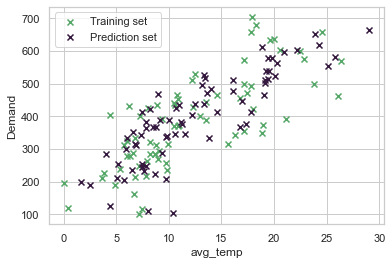

In [37]:
# fit model on training data
model_lin = LinearRegression(normalize = True)
model_lin.fit(X_train, y_train)

# prediction on test data
y_pred_lin = model_lin.predict(X_test)

# evaluate
r2_lin = r2_score(y_test, y_pred_lin)
MAE_lin =  mean_absolute_error(y_test, y_pred_lin)
MSE_lin = mean_squared_error(y_test, y_pred_lin, squared = True)
RMSE_lin = mean_squared_error(y_test, y_pred_lin, squared = False)

print (f'Linear Regression, {TIME_FRAME}ly')
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of linear regression is: ', r2_lin)
print ('The MAE  of linear regression is: ', MAE_lin)
print ('The MSE  of linear regression is: ', MSE_lin)
print ('The RMSE of linear regression is: ', RMSE_lin)

#print("Coefficients ", model.coef_, "\nIntercept ", model.intercept_ )

plt.scatter(X_train[LABEL_FOR_GRAPHS] if len(features)>1 else X_train, y_train, marker='x', color='g')
plt.scatter(X_test[LABEL_FOR_GRAPHS] if len(features)>1 else X_test, y_pred_lin, marker='x')
plt.xlabel(LABEL_FOR_GRAPHS)
plt.ylabel("Demand")
plt.legend(['Training set', 'Prediction set'])

## Model 1: polynomial regression with normalization without regularization

### select best degree

0.812678876753451  , degree:  1


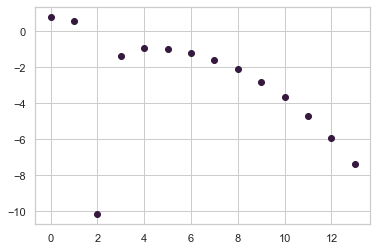

In [38]:
def polynomial_get_degrees():
    r2 = []
    for i in range (1,15):
        # generate and transform polynomial features
        poly1 = PolynomialFeatures (degree = i)
        x_poly1 = poly1.fit_transform(np.array(X_train).reshape(y_train.shape[0],-1))
            
        # fit model on training data
        model = LinearRegression(normalize = True)
        model.fit(x_poly1, y_train)

        # prediction on training data
        y_pred1 = model.predict(poly1.fit_transform(np.array(X_test).reshape(y_test.shape[0],-1)))
        
        # calc r2 score
        r2_1 = r2_score(y_test, y_pred1)
        r2.append(r2_1)
    return r2

polynomial_degrees = polynomial_get_degrees()
print (np.array(polynomial_degrees).max()," , degree: ",np.array(polynomial_degrees).argmax()+1)
plt.scatter(x=np.arange(0, len(polynomial_degrees)), y=polynomial_degrees)
model_degree = np.array(polynomial_degrees).argmax()+1

### train and evaluate model

Polynomial Regression, dayly, degree: 1
Training splits: Training set  0.5 , Test set:  0.5
Features:  ['month', 'day', 'avg_temp', 'avg_wind', 'avg_rain', 'avg_dist_from_center_end', 'is_weekday']
The R^2  of polynomial regression is:  0.812678876753451
The MAE  of polynomial regression is:  46.541779833181145
The MSE  of polynomial regression is:  4115.142955710519
The RMSE of polynomial regression is:  64.14938001033619


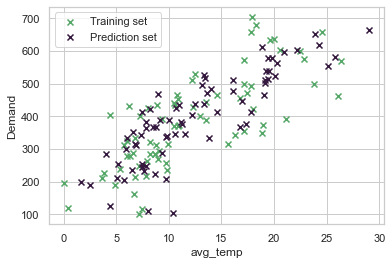

In [39]:
# generate and transform polynomial features
poly1 = PolynomialFeatures (degree = model_degree)
x_poly1 = poly1.fit_transform(np.array(X_train).reshape(y_train.shape[0],-1))

# fit model on training data
model = LinearRegression(normalize = True)
model.fit(x_poly1, y_train)

# prediction on test data
y_pred1 = model.predict(poly1.fit_transform(np.array(X_test).reshape(y_test.shape[0],-1)))

# evaluate
r2_1 = r2_score(y_test, y_pred1)
MAE_1 =  mean_absolute_error(y_test, y_pred1)
MSE_1 = mean_squared_error(y_test, y_pred1, squared = True)
RMSE_1 = mean_squared_error(y_test, y_pred1, squared = False)

print (f'Polynomial Regression, {TIME_FRAME}ly, degree: {model_degree}')
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of polynomial regression is: ', r2_1)
print ('The MAE  of polynomial regression is: ', MAE_1)
print ('The MSE  of polynomial regression is: ', MSE_1)
print ('The RMSE of polynomial regression is: ', RMSE_1)

#print("Coefficients ", model.coef_, "\nIntercept ", model.intercept_ )

plt.scatter(X_train[LABEL_FOR_GRAPHS] if len(features)>1 else X_train, y_train, marker='x', color='g')
plt.scatter(X_test[LABEL_FOR_GRAPHS] if len(features)>1 else X_test, y_pred1, marker='x')
plt.xlabel(LABEL_FOR_GRAPHS)
plt.ylabel("Demand")
plt.legend(['Training set', 'Prediction set'])

## Model 2: Ridge regression

In [40]:
from sklearn.linear_model import Ridge

### select best degree

0.8177483364151282  , degree:  2


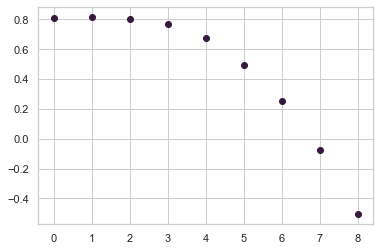

In [41]:
def polynomial_get_degrees_L2(al):
    r2 = []
    for i in range (1,10):
        # generate and transform polynomial features
        poly2 = PolynomialFeatures(degree = i)
        x_poly2 = poly2.fit_transform(np.array(X_train).reshape(y_train.shape[0],-1))

        # fit model on training data
        model_L2 = Ridge(alpha = al, normalize=True, solver = 'lsqr', max_iter=50000)
        model_L2.fit(x_poly2, y_train)

        # prediction on test data
        y_pred2 = model_L2.predict(poly2.fit_transform(np.array(X_test).reshape(y_test.shape[0],-1)))

        # calc r2 score
        r2_2 = r2_score(y_test, y_pred2)
        r2.append(r2_2)
    return r2

alpha_L2 = 0.13
polynomial_degrees_L2 = polynomial_get_degrees_L2(alpha_L2)
print (np.array(polynomial_degrees_L2).max()," , degree: ",np.array(polynomial_degrees_L2).argmax()+1)
plt.scatter(x=np.arange(0, len(polynomial_degrees_L2)), y=polynomial_degrees_L2)
model_L2_degree = np.array(polynomial_degrees_L2).argmax()+1

### train and evaluate model

Ridge Regression, dayly, lambda: 0.13, optimal degree: 2
Training splits: Training set  0.5 , Test set:  0.5
Features:  ['month', 'day', 'avg_temp', 'avg_wind', 'avg_rain', 'avg_dist_from_center_end', 'is_weekday']
The R^2  of ridge regression is:  0.8177483364151282
The MAE  of ridge regression is:  45.817089782652104
The MSE  of ridge regression is:  4003.7751032524047
The RMSE of ridge regression is:  63.275390976685436


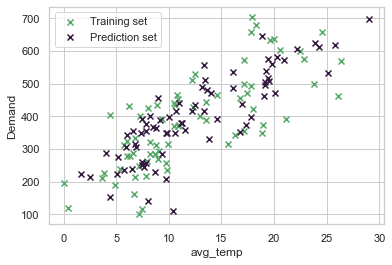

In [42]:
# generate and transform polynomial features
poly2 = PolynomialFeatures(degree = model_L2_degree)
x_poly2 = poly2.fit_transform(np.array(X_train).reshape(y_train.shape[0],-1))

# fit model on training data
model_L2 = Ridge(alpha = alpha_L2, normalize=True, solver = 'lsqr', max_iter=50000)
model_L2.fit(x_poly2, y_train)

# prediction on test data
y_pred2 = model_L2.predict(poly2.fit_transform(np.array(X_test).reshape(y_test.shape[0],-1)))

# evaluate
r2_2 = r2_score(y_test, y_pred2)
MAE_2 =  mean_absolute_error(y_test, y_pred2)
MSE_2 = mean_squared_error(y_test, y_pred2, squared = True)
RMSE_2 = mean_squared_error(y_test, y_pred2, squared = False)

print (f'Ridge Regression, {TIME_FRAME}ly, lambda: {alpha_L2}, optimal degree: {model_L2_degree}')
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of ridge regression is: ', r2_2)
print ('The MAE  of ridge regression is: ', MAE_2)
print ('The MSE  of ridge regression is: ', MSE_2)
print ('The RMSE of ridge regression is: ', RMSE_2)

#print("Coefficients ", model.coef_, "\nIntercept ", model.intercept_ )

plt.scatter(X_train[LABEL_FOR_GRAPHS] if len(features)>1 else X_train, y_train, marker='x', color='g')
plt.scatter(X_test[LABEL_FOR_GRAPHS] if len(features)>1 else X_test, y_pred2, marker='x')
plt.xlabel(LABEL_FOR_GRAPHS)
plt.ylabel("Demand")
plt.legend(['Training set', 'Prediction set'])

## Model 3: Lasso regression

In [43]:
from sklearn.linear_model import Lasso
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### select best degree

0.8132054782032903  , degree:  1


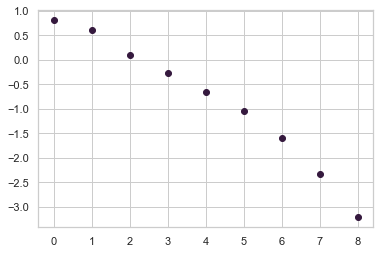

In [44]:
def polynomial_get_degrees_L1(al):
    r2 = []
    for i in range (1,10):
        # generate and transform polynomial features
        poly3 = PolynomialFeatures(degree = i)
        x_poly3 = poly3.fit_transform(np.array(X_train).reshape(y_train.shape[0],-1))

        # fit model on training data
        model_L1 = Lasso(alpha=al, max_iter=1000)
        model_L1.fit(x_poly3, y_train)

        # prediction on test data
        y_pred3 = model_L1.predict(poly3.fit_transform(np.array(X_test).reshape(y_test.shape[0],-1)))

        # calc r2 score
        r2_3 = r2_score(y_test, y_pred3)
        r2.append(r2_3)
    return r2

alpha_L1 = 0.1
polynomial_degrees_L1 = polynomial_get_degrees_L1(alpha_L1)
print (np.array(polynomial_degrees_L1).max()," , degree: ",np.array(polynomial_degrees_L1).argmax()+1)
plt.scatter(x=np.arange(0, len(polynomial_degrees_L1)), y=polynomial_degrees_L1)
model_L1_degree = np.array(polynomial_degrees_L1).argmax()+1

### train and evaluate model

#### train model 3

Lasso Regression, dayly, lambda: 0.1, optimal degree: 1
Training splits: Training set  0.5 , Test set:  0.5
Features:  ['month', 'day', 'avg_temp', 'avg_wind', 'avg_rain', 'avg_dist_from_center_end', 'is_weekday']
The R^2  of lasso regression is:  0.8132054782032903
The MAE  of lasso regression is:  46.668509094328805
The MSE  of lasso regression is:  4103.574371189909
The RMSE of lasso regression is:  64.05914744351433


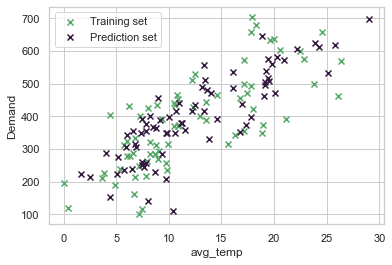

In [45]:
# generate and transform polynomial features
poly3 = PolynomialFeatures(degree = model_L1_degree)
x_poly3 = poly3.fit_transform(np.array(X_train).reshape(y_train.shape[0],-1))

# fit model on training data
model_L1 = Lasso(alpha = alpha_L1, max_iter=10000)
model_L1.fit(x_poly3, y_train)

# prediction on test data
y_pred3 = model_L1.predict(poly3.fit_transform(np.array(X_test).reshape(y_test.shape[0],-1)))

# evaluate
r2_3 = r2_score(y_test, y_pred3)
MAE_3 =  mean_absolute_error(y_test, y_pred3)
MSE_3 = mean_squared_error(y_test, y_pred3, squared = True)
RMSE_3 = mean_squared_error(y_test, y_pred3, squared = False)

print (f'Lasso Regression, {TIME_FRAME}ly, lambda: {alpha_L1}, optimal degree: {model_L1_degree}')
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of lasso regression is: ', r2_3)
print ('The MAE  of lasso regression is: ', MAE_3)
print ('The MSE  of lasso regression is: ', MSE_3)
print ('The RMSE of lasso regression is: ', RMSE_3)

#print("Coefficients ", model.coef_, "\nIntercept ", model.intercept_ )

plt.scatter(X_train[LABEL_FOR_GRAPHS] if len(features)>1 else X_train, y_train, marker='x', color='g')
plt.scatter(X_test[LABEL_FOR_GRAPHS] if len(features)>1 else X_test, y_pred2, marker='x')
plt.xlabel(LABEL_FOR_GRAPHS)
plt.ylabel("Demand")
plt.legend(['Training set', 'Prediction set'])